使用R语言实现贝叶斯网状Meta分析。

In [1]:
install.packages("gemtc")

trying URL 'https://cran.rstudio.com/bin/macosx/big-sur-arm64/contrib/4.4/gemtc_1.0-2.tgz'
Content type 'application/x-gzip' length 1171154 bytes (1.1 MB)
downloaded 1.1 MB




The downloaded binary packages are in
	/var/folders/fv/c0dh9y6s7638rh5fdr3lgcmr0000gn/T//RtmpezvGl8/downloaded_packages


In [2]:
library(gemtc)

Loading required package: coda


In [3]:
install.packages("rjags")

trying URL 'https://cran.rstudio.com/bin/macosx/big-sur-arm64/contrib/4.4/rjags_4-16.tgz'
Content type 'application/x-gzip' length 321144 bytes (313 KB)
downloaded 313 KB




The downloaded binary packages are in
	/var/folders/fv/c0dh9y6s7638rh5fdr3lgcmr0000gn/T//RtmpezvGl8/downloaded_packages


In [4]:
library(rjags)

Linked to JAGS 4.3.2
Loaded modules: basemod,bugs


# 数据准备

In [5]:
load("dmatar_data/TherapyFormats.rda")

In [6]:
head(TherapyFormats)

         author     TE  seTE treat1 treat2 treat1.long treat2.long     versus
1  Ausbun, 1997  0.092 0.195    ind    grp  Individual       Group ind vs grp
2  Crable, 1986 -0.675 0.350    ind    grp  Individual       Group ind vs grp
3  Thiede, 2011 -0.107 0.198    ind    grp  Individual       Group ind vs grp
4 Bonertz, 2015 -0.090 0.324    ind    grp  Individual       Group ind vs grp
5     Joy, 2002 -0.135 0.453    ind    grp  Individual       Group ind vs grp
6   Jones, 2013 -0.217 0.289    ind    grp  Individual       Group ind vs grp

In [7]:
load("dmatar_data/TherapyFormatsGeMTC.rda")

In [8]:
head(TherapyFormatsGeMTC$data)

         study   diff std.err treatment
1 Ausbun, 1997  0.092   0.195       ind
2 Ausbun, 1997     NA      NA       grp
3 Crable, 1986 -0.675   0.350       ind
4 Crable, 1986     NA      NA       grp
5 Thiede, 2011 -0.107   0.198       ind
6 Thiede, 2011     NA      NA       grp

In [9]:
summary(TherapyFormatsGeMTC)

            Length Class      Mode
data        4      data.frame list
study.info  2      data.frame list
treat.codes 2      data.frame list

In [10]:
TherapyFormatsGeMTC$treat.codes

   id        description
1 ind         Individual
2 grp              Group
3 gsh   Guided Self-Help
4 tel          Telephone
5 wlc           Waitlist
6 cau      Care As Usual
7 ush Unguided Self-Help

# 网络图

In [11]:
network <- mtc.network(
  data.re = TherapyFormatsGeMTC$data,
  treatments = TherapyFormatsGeMTC$treat.codes
)

In [12]:
summary(network)

$Description
[1] "MTC dataset: Network"

$`Studies per treatment`
ind grp gsh tel wlc cau ush 
 62  52  57  11  83  74  26 

$`Number of n-arm studies`
2-arm 3-arm 
  181     1 

$`Studies per treatment comparison`
    t1  t2 nr
1  ind tel  4
2  ind wlc 18
3  grp ind  7
4  grp gsh  5
5  grp wlc 18
6  grp ush  1
7  gsh ind  4
8  gsh wlc 36
9  gsh ush  5
10 tel wlc  1
11 cau ind 30
12 cau grp 21
13 cau gsh  8
14 cau tel  6
15 cau ush  9
16 ush wlc 11


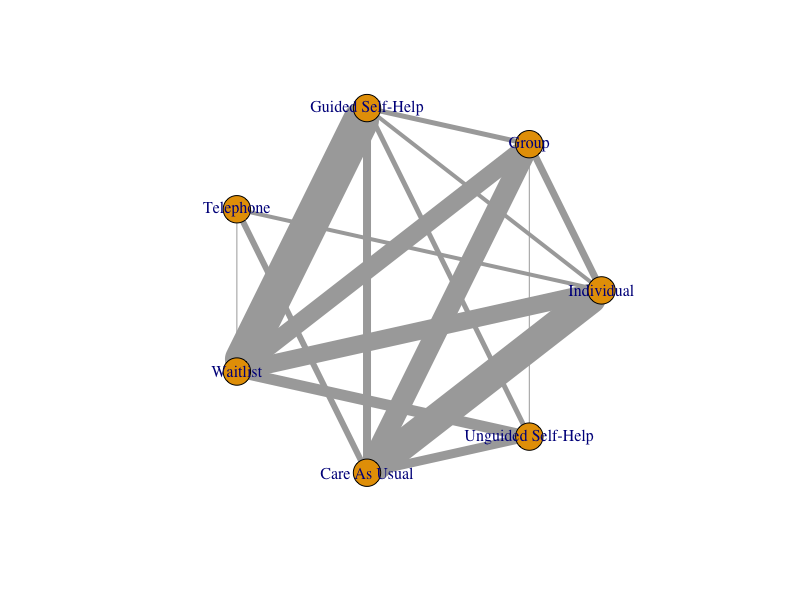

In [13]:
plot(
  network,
  use.description = TRUE # 使用治疗方式完整名称
)


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



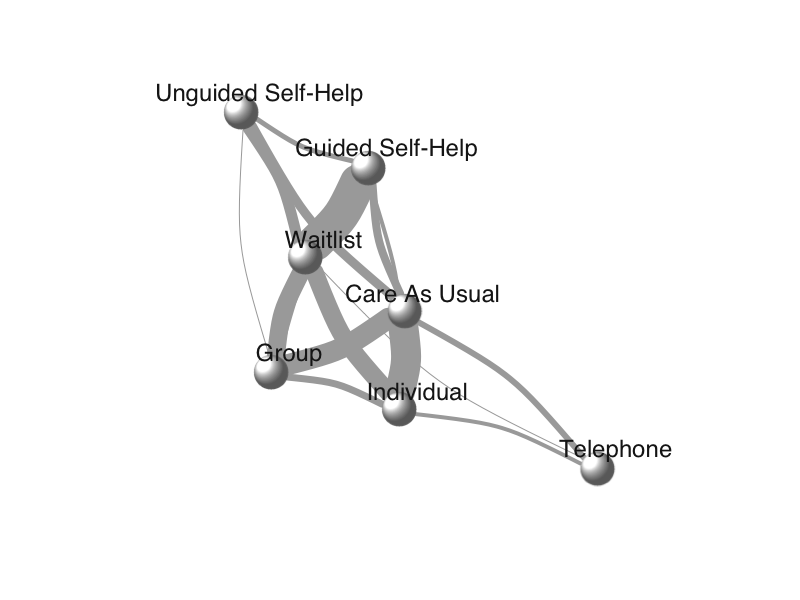

In [14]:
library(igraph)
set.seed(12345) # set seed for reproducibility

plot(
  network, 
  use.description = TRUE,            # Use full treatment names
  vertex.color = "white",            # node color
  vertex.label.color = "gray10",     # treatment label color
  vertex.shape = "sphere",           # shape of the node
  vertex.label.family = "Helvetica", # label font
  vertex.size = 20,                  # size of the node
  vertex.label.dist = 2,             # distance label-node center
  vertex.label.cex = 1.5,            # node label size
  edge.curved = 0.2,                 # edge curvature
  layout = layout.fruchterman.reingold
)

# 模型编译

In [15]:
model <- mtc.model(
  network,
  likelihood = "normal",
  link = "identity",
  linearModel = "random",
  n.chain = 4
)

# MCMC采样

In [16]:
mcmc1 <- mtc.run(model, n.adapt = 50, n.iter = 1000, thin = 10)
mcmc2 <- mtc.run(model, n.adapt = 5000, n.iter = 1e5, thin = 10)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 182
   Unobserved stochastic nodes: 190
   Total graph size: 2606

Initializing model

NOTE: Stopping adaptation


  |**************************************************| 100%


Warning message:
In rjags::jags.model(file.model, data = syntax[["data"]], inits = syntax[["inits"]],  :
  Adaptation incomplete


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 182
   Unobserved stochastic nodes: 190
   Total graph size: 2606

Initializing model

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100%
  |**************************************************| 100%


# 评估模型收敛性

In [17]:
plot(mcmc1)
plot(mcmc2)

: [1m[33mError[39m in `plot.new()`:[22m
[33m![39m figure margins too large

In [18]:
gelman.plot(mcmc1)
gelman.plot(mcmc2)

: [1m[33mError[39m in `plot.new()`:[22m
[33m![39m figure margins too large

In [19]:
gelman.diag(mcmc1)$mpsrf

[1] 1.071288

In [20]:
gelman.diag(mcmc2)$mpsrf

[1] 1.000378

# 评估不一致性

In [21]:
nodesplit <- mtc.nodesplit(
  network,
  linearModel = "random",
  likelihood = "normal",
  link = "identity",
  n.adapt = 5000,
  n.iter = 1e5,
  thin = 10
)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 182
   Unobserved stochastic nodes: 191
   Total graph size: 2746

Initializing model

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100%
  |                                                        

In [22]:
plot(summary(nodesplit)) 

: [1m[33mError[39m:[22m
[33m![39m object 'nodesplit' not found

# 生成网状Meta分析的结果

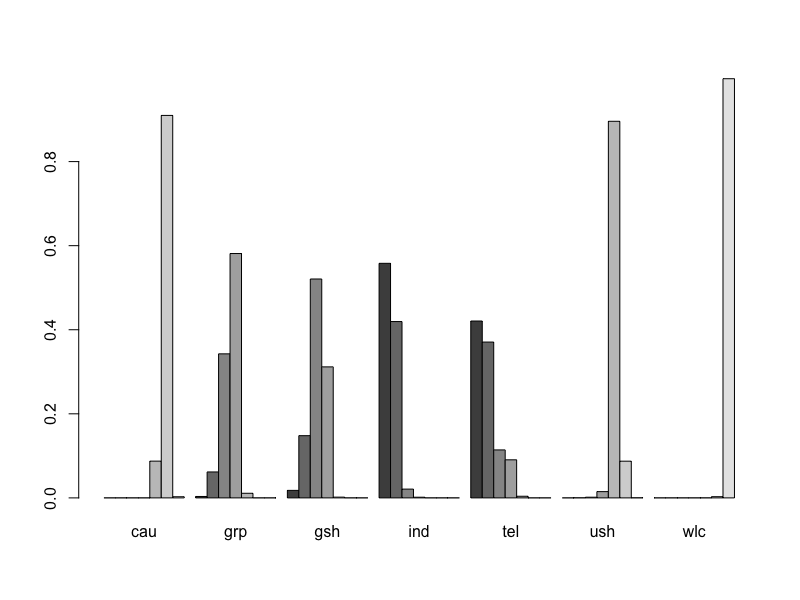

In [23]:
rank <- rank.probability(mcmc2, preferredDirection = -1)
plot(rank, beside=TRUE)

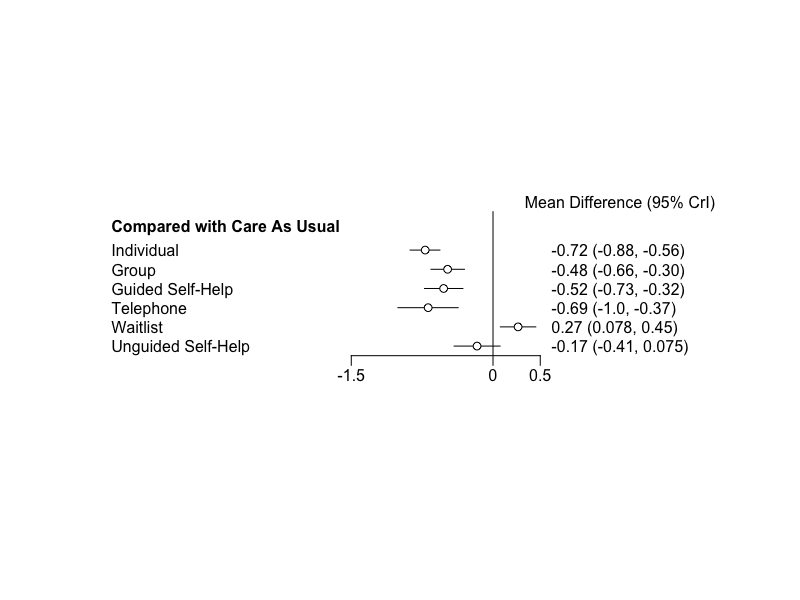

In [24]:
forest(
  relative.effect(mcmc2, t1 = "cau"),
  use.description = TRUE,
  xlim = c(-1.5, 0.5)
)

In [25]:
#' Calculate the Surface Under the Cumulative Ranking score of from a network meta-analysis
#'
#' This function calculates the SUCRA (Surface Under the Cumulative Ranking) score from a rank
#' probability matrix or an object of class \code{mtc.rank.probability} generated by the \code{\link[gemtc]{rank.probability}}
#' function.
#'
#' @usage sucra(x, lower.is.better = FALSE)
#'
#' @param x An object of class \code{mtc.rank.probability} generated by the \code{\link[gemtc]{rank.probability}} function
#' or a matrix/data.frame in which the rows correspond to the treatment, and columns to the
#' probability of a specific treatment having this rank (see Details). Rownames of the matrix should
#' contain the name of the specific treatment.
#' @param lower.is.better Logical. Do lower (i.e., more negative) effect sizes mean that effects are
#' higher? \code{FALSE} by default. Use the default when the provided matrix already contains the
#' correct rank probability for each treatment, and values ought not to be inverted.
#'
#' @details The SUCRA score is a metric to evaluate which treatment in a network is likely
#' to be the most efficacious in the context of network meta-analyses. The SUCRA score is calculated
#' in the function using the formula described in Salanti, Ades and Ioannidis (2011):
#' \deqn{SUCRA_j = \frac{\sum_{b=1}^{a-1}cum_{jb}}{a-1}}
#' Where \eqn{j} is some treatment, \eqn{a} are all competing treatments, \eqn{b} are the
#' \eqn{b = 1, 2, ..., a-1} best treatments, and \eqn{cum} represents the cumulative probability
#' of a treatment being among the \eqn{b} best treatments.
#'
#' Other than an object of class \code{mtc.rank.probability} for argument \code{x}, the function can also be provided
#' with a \eqn{m \times n} matrix where \eqn{m} are rows corresponding to each treatment in the
#' network meta-analysis, and the \eqn{n} columns correspond to each rank (1st, 2nd, etc.). Rank probabilities
#' should be provided as a value from 0 to 1. Rownames of the matrix should correspond to the treatment names.
#' Here is an example rank probability matrix for eight treatments:
#'
#' \tabular{lrrrrrrrr}{
#' . \tab [,1] \tab [,2] \tab [,3] \tab [,4] \tab [,5] \tab [,6] \tab [,7] \tab [,8]\cr
#' CBT \tab 0.000000 \tab 0.000000 \tab 0.000000 \tab 0.000000 \tab 0.000000 \tab 0.001275 \tab 0.087400 \tab 0.911325\cr
#' IPT \tab 0.000000 \tab 0.000000 \tab 0.000000 \tab 0.000000 \tab 0.000000 \tab 0.179400 \tab 0.745875 \tab 0.074725\cr
#' PDT \tab 0.000000 \tab 0.000000 \tab 0.000225 \tab 0.020300 \tab 0.978025 \tab 0.001450 \tab 0.000000 \tab 0.000000\cr
#' PLA \tab 0.002825 \tab 0.551175 \tab 0.262525 \tab 0.181550 \tab 0.001925 \tab 0.000000 \tab 0.000000 \tab 0.000000\cr
#' PST \tab 0.000000 \tab 0.000000 \tab 0.000000 \tab 0.000025 \tab 0.001450 \tab 0.817850 \tab 0.166725 \tab 0.013950\cr
#' SUP \tab 0.000000 \tab 0.216450 \tab 0.398700 \tab 0.383950 \tab 0.000900 \tab 0.000000 \tab 0.000000 \tab 0.000000\cr
#' TAU \tab 0.000375 \tab 0.229200 \tab 0.338525 \tab 0.414175 \tab 0.017700 \tab 0.000025 \tab 0.000000 \tab 0.000000\cr
#' WLC \tab 0.996800 \tab 0.003175 \tab 0.000025 \tab 0.000000 \tab 0.000000 \tab 0.000000 \tab 0.000000 \tab 0.000000
#' }
#'
#' @references Harrer, M., Cuijpers, P., Furukawa, T.A, & Ebert, D. D. (2019).
#' \emph{Doing Meta-Analysis in R: A Hands-on Guide}. DOI: 10.5281/zenodo.2551803.
#' \href{https://bookdown.org/MathiasHarrer/Doing_Meta_Analysis_in_R/bayesian-network-meta-analysis.html}{Chapter 11.2}.
#'
#'Salanti, G., Ades, A. E. & Ioannidis, J.P.A. (2011). Graphical Methods and Numerical Summaries for
#'Presenting Results from Multiple-Treatment Meta-Analysis: An Overview and Tutorial.
#'\emph{Journal of Clinical Epidemiology, 64} (2): 163–71.
#'
#' @author Mathias Harrer & David Daniel Ebert
#'
#' @import ggplot2
#'
#' @export sucra
#'
#' @seealso
#' \code{\link{direct.evidence.plot}}
#'
#' @examples
#' \dontrun{
#' # Example1 : conduct NMA using gemtc, calculate SUCRAs
#' suppressPackageStartupMessages(library(gemtc))
#' suppressPackageStartupMessages(library(igraph))
#' data("NetDataGemtc")
#'
#' network = suppressWarnings(mtc.network(data.re = NetDataGemtc))
#'
#' plot(network, layout = layout.fruchterman.reingold)
#'
#' model = mtc.model(network, linearModel = "fixed",
#'                    n.chain = 4,
#'                    likelihood = "normal",
#'                    link = "identity")
#'
#' mcmc = mtc.run(model, n.adapt = 5000, n.iter = 100000, thin = 10)
#'
#' rp = rank.probability(mcmc)
#'
#' sucra = sucra(rp, lower.is.better = TRUE)
#' sucra
#' plot(sucra)}
#'
#'
#'
#' # Example 2: construct rank proabability matrix, then use sucra function
#' rp = rbind(CBT = c(0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.001500, 0.088025, 0.910475),
#'            IPT = c(0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.176975, 0.748300, 0.074725),
#'            PDT = c(0.000000, 0.000000, 0.000250, 0.021725, 0.976525, 0.001500, 0.000000, 0.000000),
#'            PLA = c(0.003350, 0.546075, 0.266125, 0.182125, 0.002325, 0.000000, 0.000000, 0.000000),
#'            PST = c(0.000000, 0.000000, 0.000000, 0.000000, 0.001500, 0.820025, 0.163675, 0.014800),
#'            SUP = c(0.000000, 0.217450, 0.403950, 0.378000, 0.000600, 0.000000, 0.000000, 0.000000),
#'            TAU = c(0.000225, 0.232900, 0.329675, 0.418150, 0.019050, 0.000000, 0.000000, 0.000000),
#'            WLC = c(0.996425, 0.003575, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000))
#'
#' sucra(rp, lower.is.better = TRUE)
#' plot(sucra(rp, lower.is.better = TRUE))


sucra = function(x, lower.is.better = FALSE) {

  rank.probability = x


  # Convert rank.probability to matrix
  mat = as.matrix(rank.probability)

  # Loop over treatments, for each treatment: calculate SUCRA
  a = ncol(mat)
  j = nrow(mat)
  names = rownames(mat)

  sucra = numeric()
  for (x in 1:j) {
      sucra[x] = sum(cumsum(mat[x, 1:(a - 1)]))/(a - 1)
  }

  # If condition for lower.is.better
  if (lower.is.better == TRUE) {
      sucra = numeric()
      for (x in 1:j) {
          sucra[x] = 1 - sum(cumsum(mat[x, 1:(a - 1)]))/(a - 1)
      }
  }

  # Make data.frame
  res = data.frame(Treatment = names, SUCRA = sucra)

  # Order
  res = res[order(-res$SUCRA), ]
  rownames(res) = 1:j

  rownames(res) = res$Treatment
  res$Treatment = NULL

  class(res) = "sucra"

  invisible(res)

  res

}


In [26]:
rank_probability <- rank.probability(mcmc2)
sucra <- sucra(rank_probability, lower.is.better = TRUE)
sucra

$SUCRA
[1] 0.9223166667 0.8523083333 0.6447541667 0.5775333333 0.3218166667
[6] 0.1807916667 0.0004791667

attr(,"row.names")
[1] "ind" "tel" "gsh" "grp" "ush" "cau" "wlc"
attr(,"class")
[1] "sucra"

In [27]:
library(ggplot2)
plot(sucra)

: [1m[33mError[39m in `xy.coords()`:[22m
[33m![39m 'x' is a list, but does not have components 'x' and 'y'

In [28]:
rank_probability

Rank probability; preferred direction = 1
       [,1]     [,2]     [,3]    [,4]     [,5]     [,6]     [,7]
cau 0.00270 0.909850 0.087450 0.00000 0.000000 0.000000 0.000000
grp 0.00000 0.000000 0.010975 0.58130 0.342650 0.061700 0.003375
gsh 0.00000 0.000000 0.001775 0.31165 0.520725 0.147975 0.017875
ind 0.00000 0.000000 0.000000 0.00160 0.020900 0.419500 0.558000
tel 0.00000 0.000000 0.003900 0.09055 0.114100 0.370700 0.420750
ush 0.00015 0.087325 0.895875 0.01490 0.001625 0.000125 0.000000
wlc 0.99715 0.002825 0.000025 0.00000 0.000000 0.000000 0.000000

In [38]:
saveRDS(rank_probability, "rank_probability.rds")

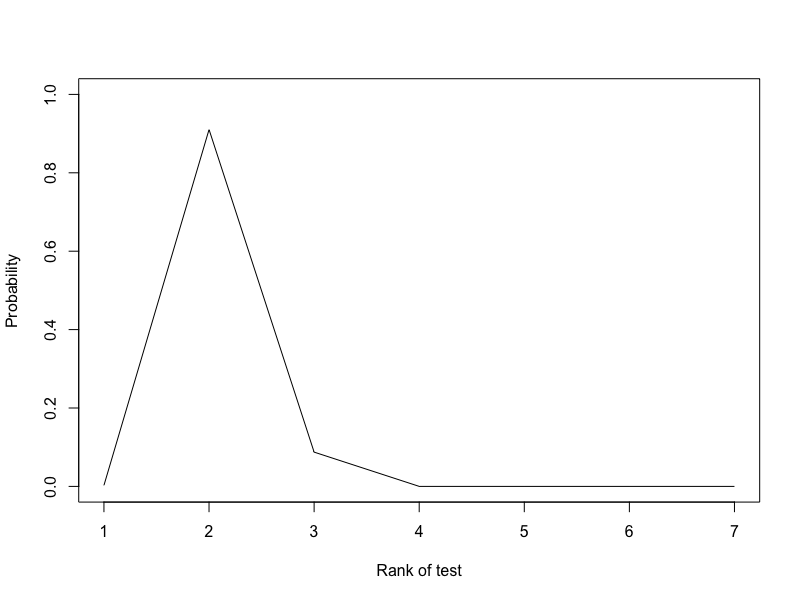

In [34]:
plot(1:7, rank_probability[c(1), ], type="l", xlab = "Rank of test", ylab = "Probability", ylim = c(0, 1))

In [39]:
rank.plot <- function(rank_probability, num) {
  # 获取治疗方式数量和每个治疗方式的排名数量
  m <- dim(rank_probability)[1]  # 图像数量，即治疗方式的数量
  n <- dim(rank_probability)[2]  # x轴长度，即每个治疗方式的排名数量

  # 计算布局：行数与列数
  cols <- num  # 列的数量
  rows <- ceiling(m / cols)      # 行的数量，使用天花板函数确保有足够的空间显示所有图像

  # 获取行名，从而设置x轴标签
  row_names <- rownames(rank_probability)
  
  # 设定绘图布局
  par(mfrow = c(rows, cols))     # 设置多图环境，rows行cols列

  # 循环遍历每个治疗方式并绘制对应的图表
  for (i in 1:m) {
    plot(
      1:n, 
      rev(rank_probability[i,]),  # 发现这个向量好像是反的，不能直接用
      type="o", 
      xlab=paste("Rank of", row_names[i]), 
      ylab="Probability"
    )
  }

  # 重置图形参数为默认值
  par(mfrow = c(1, 1))
}

rank.plot(rank_probability, 3)


: [1m[33mError[39m in `plot.new()`:[22m
[33m![39m figure margins too large

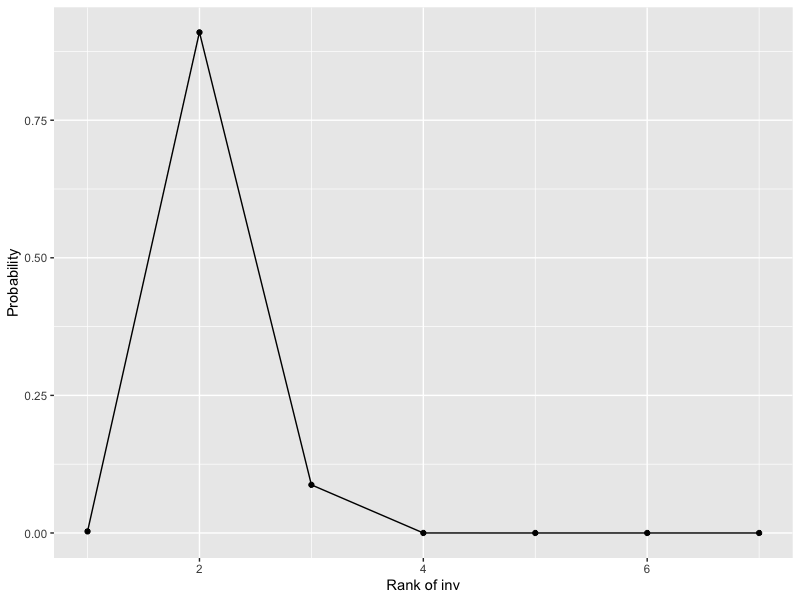

In [ ]:
library(ggplot2)

# 绘制单种治疗方式的SUCRA曲线
rank_line <- function(probabilities, treatment_name, n) {
  # probabilitiess是概率数据
  # treatment_name是治疗方式的名称
  # n是概率数据的长度，为了加快运行速度，预先指定

  # 创建一个数据框，包含x轴（排名位置）和y轴（累积概率）
  df <- data.frame(
    rank = 1:n,
    probabilities = probabilities
  )
  
  # 使用ggplot2绘制累积概率曲线
  ggplot(df, aes(x = rank, y = probabilities)) +
    geom_line() +  # 绘制线条
    geom_point() + # 可选：添加点以更清晰地显示数据点
    labs(
      x = paste("Rank of", treatment_name),
      y = "Probability"
    )
}

# 使用facet绘制rank_probability所有行的图
ran_plot <- function(rank_probability){
  
}

Warning messages:
1: In plot.window(xlim, ylim, log = log, ...) :
  graphical parameter "type" is obsolete
2: In axis(if (horiz) 2 else 1, at = at.l, labels = names.arg, lty = axis.lty,  :
  graphical parameter "type" is obsolete
3: In title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...) :
  graphical parameter "type" is obsolete
4: In axis(if (horiz) 1 else 2, cex.axis = cex.axis, ...) :
  graphical parameter "type" is obsolete


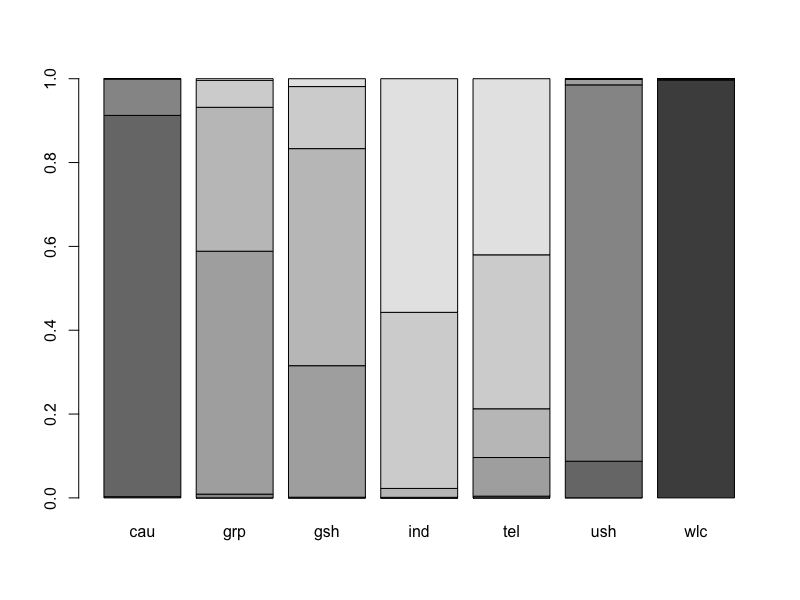

In [ ]:
# 绘制排序图


rank_plot <- function(model){

}

In [ ]:
result <- relative.effect.table(mcmc2)
result

Mean Difference (95% CrI)

            ind              0.2369 (0.04217, 0.4365)    0.1967 (-0.01332, 0.4039)   0.03177 (-0.2958, 0.3583)    0.9842 (0.8028, 1.167)      0.7186 (0.5615, 0.8755)     0.5504 (0.2919, 0.8101)  
-0.2369 (-0.4365, -0.04217)             grp             -0.04056 (-0.2518, 0.1649)   -0.205 (-0.5623, 0.1442)     0.7461 (0.5599, 0.9316)     0.4814 (0.3044, 0.6579)    0.3125 (0.05362, 0.5756)  
-0.1967 (-0.4039, 0.01332)   0.04056 (-0.1649, 0.2518)              gsh              -0.1633 (-0.5264, 0.1952)    0.7875 (0.6328, 0.9452)     0.5225 (0.3201, 0.7266)     0.3533 (0.1071, 0.6022)  
-0.03177 (-0.3583, 0.2958)    0.205 (-0.1442, 0.5623)    0.1633 (-0.1952, 0.5264)               tel               0.9511 (0.6059, 1.301)      0.6862 (0.3677, 1.009)      0.5171 (0.1287, 0.908)   
 -0.9842 (-1.167, -0.8028)  -0.7461 (-0.9316, -0.5599)  -0.7875 (-0.9452, -0.6328)   -0.9511 (-1.301, -0.6059)              wlc             -0.2649 (-0.4513, -0.07979)  -0.434 (-0.6634, -0.

# 网状Meta回归

In [40]:
TherapyFormatsGeMTC$study.info

                       study rob
1             Campbell, 2000   1
2             Reynolds, 1989   1
3            Carpenter, 1994   0
4             Shrednik, 2000   1
5               Lesley, 1999   1
6                Wyatt, 2003   0
7                Lemon, 2005   1
8                James, 2012   0
9              Graesch, 2000   0
10               Lange, 1993   1
11         Marinkovich, 2003   1
12              Wuertz, 2016   1
13              Hughey, 2012   1
14               Dobbs, 2000   1
15               Quick, 2006   1
16             Harbert, 1999   1
17              Nelson, 1987   1
18          Watkins Jr, 2004   1
19              Ristau, 1992   1
20            Schlegel, 1989   1
21            Wierenga, 2004   1
22               Laird, 2008   1
23               Riley, 2002   1
24            Germuska, 1996   0
25            Schulker, 2009   1
26             Barrett, 2005   1
27                Neil, 2015   1
28             Congour, 1996   1
29               Hurla, 1985   1
30        

In [41]:
network_mr <- mtc.network(
  data.re = TherapyFormatsGeMTC$data,
  studies = TherapyFormatsGeMTC$study.info,
  treatments = TherapyFormatsGeMTC$treat.codes
)

In [46]:
regressor <- list(
  coefficient = "shared",
  variable = "rob",
  control = "cau"
)

In [47]:
model_mr <- mtc.model(
  network_mr,
  likelihood = "normal",
  link = "identity",
  type = "regression",
  regressor = regressor
)

In [48]:
mcmc3 <- mtc.run(
  model_mr,
  n.adapt = 5000,
  n.iter = 1e5,
  thin = 10
)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 182
   Unobserved stochastic nodes: 191
   Total graph size: 2980

Initializing model

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100%
  |**************************************************| 100%


In [49]:
summary(mcmc3)


Results on the Mean Difference scale

Iterations = 5010:105000
Thinning interval = 10 
Number of chains = 4 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

              Mean      SD  Naive SE Time-series SE
d.ind.cau  0.69927 0.07956 0.0003978      0.0004142
d.ind.grp  0.19301 0.10017 0.0005009      0.0005271
d.ind.gsh  0.16021 0.10507 0.0005253      0.0005580
d.ind.tel  0.02297 0.16467 0.0008234      0.0008234
d.ind.wlc  0.95062 0.09198 0.0004599      0.0004972
d.wlc.ush -0.45560 0.11534 0.0005767      0.0005865
sd.d       0.47002 0.03407 0.0001703      0.0001731
B         -0.33001 0.12965 0.0006483      0.0010135

2. Quantiles for each variable:

               2.5%      25%      50%     75%    97.5%
d.ind.cau  0.545388  0.64551  0.69909  0.7527  0.85555
d.ind.grp -0.003193  0.12508  0.19235  0.2605  0.39125
d.ind.gsh -0.046694  0.09023  0.15998  0.2309  0.36627
d.ind.tel -0.303826 -0.08715  0.02351  

In [50]:
forest(relative.effect(mcmc3, t1 = "cau", covariate = 1),
       use.description = TRUE, xlim = c(-1.5, 1))
title("High Risk of Bias")
        
forest(relative.effect(mcmc3, t1 = "cau", covariate = 0),
       use.description = TRUE, xlim = c(-1.5, 1))
title("Low Risk of Bias")

: [1m[33mError[39m in `plot.new()`:[22m
[33m![39m figure margins too large